In [2]:
import numpy
import pandas as pd
from sklearn.feature_extraction import DictVectorizer

df = pd.read_csv('./train.csv', sep=';')
df_test = pd.read_csv('./test.csv', sep=';', names=df.columns)
index_df_test = []
for i in range(df.shape[0], df.shape[0] + df_test.shape[0]):
    index_df_test.append(i)
df_test = df_test.set_index([index_df_test])

frame = pd.concat([df])
frame = frame.drop(['month', 'day_of_week'], axis=1)
# pair with cata, type
numerique = [c for c, d in zip(frame.columns, frame.dtypes) if d == numpy.int64]
categories = [c for c in frame.columns if c not in numerique and c not in ["y"]]
num = frame[numerique]
cat = frame[categories]

#Transforms lists of feature-value mappings to vectors.
# If have the feature, note 1, otherwise 0 
prep = DictVectorizer()
cat_as_dicts = [dict(r.iteritems()) for _, r in cat.iterrows()]
cat_exp = prep.fit_transform(cat_as_dicts).toarray()
#Change it to columns, and names are the feature names 
cat_exp_df = pd.DataFrame(cat_exp, columns=prep.feature_names_)

reject = ['education=unknown', 'contact=unknown']
#Noise:
#'default=no', 'education=unknown', 'contact=unknown', 'housing=no', 'job=unknown', 'loan=no',
#          'poutcome=unknown'

keep = [c for c in cat_exp_df.columns  if c not in reject ]
cat_exp_df_nocor = cat_exp_df[keep]
X = pd.concat([num, cat_exp_df], axis=1)
target = df["y"]
Y = target.apply(lambda r: (1 if r == "yes" else 0))


In [3]:
cat_exp_df.head(10)

,cons.conf.idx,cons.price.idx,contact=cellular,contact=telephone,default=no,default=unknown,education=basic.4y,education=basic.6y,education=basic.9y,education=high.school,...,loan=unknown,loan=yes,marital=divorced,marital=married,marital=single,marital=unknown,nr.employed,poutcome=failure,poutcome=nonexistent,poutcome=success
0,-46.2,92.893,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,5099.1,0.0,1.0,0.0
1,-36.4,93.994,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,5191.0,0.0,1.0,0.0
2,-41.8,94.465,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,5228.1,0.0,1.0,0.0
3,-41.8,94.465,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,5228.1,0.0,1.0,0.0
4,-42.0,93.200,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,5195.8,0.0,1.0,0.0
5,-37.5,94.199,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,4963.6,1.0,0.0,0.0
6,-37.5,94.199,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,4963.6,0.0,1.0,0.0
7,-42.0,93.200,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,5195.8,0.0,1.0,0.0
8,-42.0,93.200,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,5195.8,1.0,0.0,0.0
9,-36.4,93.994,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,5191.0,0.0,1.0,0.0


In [4]:
# seperate a test set

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [5]:
from sklearn import svm
from sklearn.metrics import matthews_corrcoef
#Compute the Matthews correlation coefficient (MCC) for binary classes

clf = svm.SVC(kernel='linear', C=0.1, class_weight={0: 1, 1: 10})
clf.fit(X_train, Y_train.ravel())
print " MCC is : %f" %(matthews_corrcoef(Y_test, clf.predict(X_test)))
print "The accuracy of SVM that I got is: %f" %clf.score(X_test, Y_test)

 MCC is : 0.468438
The accuracy of SVM that I got is: 0.848333


In [6]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=50)
neigh.fit(X_train, Y_train.ravel())
print " MCC of KNN is : %f" %(matthews_corrcoef(Y_test, neigh.predict(X_test)))
print "The accuracy of KNN that I got is: %f" %neigh.score(X_test, Y_test)

 MCC of KNN is : 0.434257
The accuracy of KNN that I got is: 0.908333


In [7]:
#xGBoost, the best that i know
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=20,learning_rate=0.1,n_estimators=1000)
xgb.fit(X_train, Y_train.ravel())
print " MCC of XGBOOST is : %f" %(matthews_corrcoef(Y_test, xgb.predict(X_test)))
print "The accuracy of XGBOOST that I got is: %f" %xgb.score(X_test, Y_test)

/home/zz/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



 MCC of XGBOOST is : 0.468500
The accuracy of XGBOOST that I got is: 0.905000


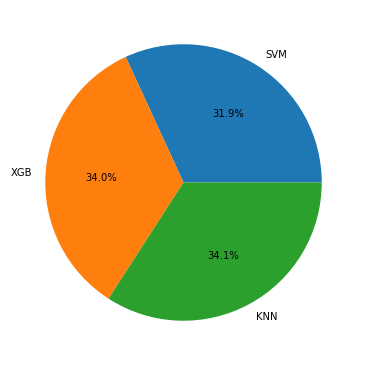

In [27]:
from matplotlib import pyplot as plt
labels = 'SVM','XGB','KNN'
fig = plt.figure(1, figsize=(6,6))
fracs = [0.848, 0.905, 0.908]
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
patches, texts, autotexts = ax.pie(fracs, labels=labels, autopct='%1.1f%%')
plt.show()

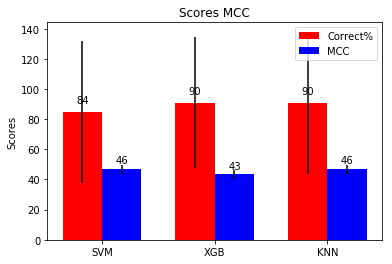

In [44]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt

N = 3
score = (84.833335, 90.8333, 90.5000)
score_std = (3, 3, 3)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, score, width, color='r', yerr=mcc)

mcc = (46.8438, 43.4257, 46.8500)
mcc_std = (3, 3, 3)
rects2 = ax.bar(ind + width, mcc, width, color='b', yerr=mcc_std)

# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Scores MCC')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('SVM', 'XGB', 'KNN'))

ax.legend((rects1[0], rects2[0]), ('Correct%', 'MCC'))

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.show()